# 영화 요약 정보를 이용한 장르 분류( Softmax Regression & MLP )

## Data Preprocessing

### 영화 요약 정보 데이터 프레임 생성

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
movie_df = pd.read_csv( 'movie_reviews.csv' )

In [4]:
movie_df.head()

,Unnamed: 0,title,story,genre,genre_code
0,0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마,0
1,1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마,0
2,2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험,1
3,3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리,2
4,4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션,3


In [5]:
movie_df.drop( movie_df.columns[ [ 0 ] ], axis = 'columns' )

,title,story,genre,genre_code
0,그린 북,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,드라마,0
1,가버나움,나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 1...,드라마,0
2,베일리 어게인,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다...,모험,1
3,주전장,일본의 인종차별 문제를 다룬 영상을 올린 후 우익들의 공격 대상이 된 일본계 미국인...,다큐멘터리,2
4,포드 V 페라리,1960년대 매출 감소에 빠진 포드는 판매 활로를 찾기 위해스포츠카 레이스를 장악한...,액션,3
...,...,...,...,...
1102,개들의 섬,인류를 위협하는 개 독감이 퍼지자 세상의 모든 개들은 쓰레기 섬으로 추방되고 자신이...,애니메이션,5
1103,위대한 개츠비,1922년 뉴욕 외곽에서 살고 있는 닉은 호화로운 별장에 살고 있는 이웃 개츠비에게...,드라마,0
1104,샬롯의 거미줄,어느 봄 비바람치던 밤에 세상에 태어난 새끼 돼지 윌버 너무 조그맣다는 이유로 윌버...,코미디,11
1105,사쿠란,안노 모요코의 동명의 인기 만화를 영화화하는 작품벚꽃이 한창인 봄 8세 나이로 요시...,드라마,0


In [6]:
movie_df.shape

(1107, 5)

### softmax regression에 사용할 변수 생성

In [7]:
movie_title = np.array( movie_df[ 'title' ].values ) # 영화 제목
movie_storys = np.array( movie_df[ 'story' ].values ) # 영화 줄거리
movie_genres = np.array( movie_df[ 'genre' ].values ) # 영화 장르
movie_genre_codes = np.array( movie_df[ 'genre_code' ].values ) # 영화 장르 코드

In [8]:
genres_list = movie_df[ 'genre' ].unique().tolist()
genre_code_dict = dict( ( c, i ) for i, c in enumerate( genres_list ) )
genre_code_dict

{'드라마': 0,
 '모험': 1,
 '다큐멘터리': 2,
 '액션': 3,
 'SF': 4,
 '애니메이션': 5,
 '범죄': 6,
 '멜로/로맨스': 7,
 '전쟁': 8,
 '가족': 9,
 '판타지': 10,
 '코미디': 11,
 '공연실황': 12,
 '한국': 13,
 '서부': 14,
 '뮤지컬': 15,
 '공포': 16,
 '미스터리': 17,
 '스릴러': 18,
 '느와르': 19,
 '서스펜스': 20}

In [9]:
# 전체 데이터 중 학습할 데이터와 평가할 데이터 개수 계산
n_of_train = int( len( movie_storys ) * 0.3 ) # 전체 데이터의 30%를 학습에 사용
n_of_test = int( len( movie_storys ) - n_of_train )
print( '학습에 사용할 데이터 : {0}\t평가에 사용할 데이터 : {1}'.format( n_of_train, n_of_test ) )

학습에 사용할 데이터 : 332	평가에 사용할 데이터 : 775


In [10]:
max_sample_length = len( movie_storys )
print( '전체 샘플의 개수 : {}'.format( max_sample_length ) )

전체 샘플의 개수 : 1107


In [11]:
genres_list = movie_df[ 'genre' ].unique().tolist()
num_classes = len( genres_list )
print( '총 장르의 개수 : {}'.format( num_classes ) )

총 장르의 개수 : 21


### 학습할 데이터 내용 확인

In [12]:
print( '첫번째 샘플 영화의 장르 : {}'.format( movie_genres[ 0 ] ) )

첫번째 샘플 영화의 장르 : 드라마


In [13]:
print('첫번째 샘플 영화의 장르 코드 : {}'.format( genre_code_dict[ movie_genres[ 0 ] ] ) )

첫번째 샘플 영화의 장르 코드 : 0


In [14]:
movie_storys.ndim, movie_storys.shape # 영화 review

(1, (1107,))

In [15]:
movie_genres.ndim, movie_genres.shape # 영화 장르

(1, (1107,))

In [16]:
movie_genre_codes.ndim, movie_genre_codes.shape # 영화 장르 코드

(1, (1107,))

In [17]:
movie_storys[ :3 ]

array(['1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아함 그 자체인천재 피아니스트 돈 셜리마허샬라 알리 박사의 운전기사 면접을 보게 된다백악관에도 초청되는 등 미국 전역에서 콘서트 요청을 받으며 명성을 떨치고 있는 돈 셜리는위험하기로 소문난 미국 남부 투어 공연을 떠나기로 결심하고투어 기간 동안 자신의 보디가드 겸 운전기사로 토니를 고용한다거친 인생을 살아온 토니 발레롱가와 교양과 기품을 지키며 살아온 돈 셜리 박사생각 행동 말투 취향까지 달라도 너무 다른 두 사람은그들을 위한 여행안내서 그린북에 의존해 특별한 남부 투어를 시작하는데',
       '나를 세상에 태어나게 한 부모님을 고소하고 싶어요출생기록조차 없이 살아온 어쩌면 12살 소년 자인으로부터',
       '귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다하지만 눈을 떠보니 다시 시작된 견생 2회차 아니 3회차1등 경찰견 엘리에서 찰떡같이 마음을 알아주는 소울메이트 티노까지다시 태어날 때마다 성별과 생김새 직업에 이름도 바뀌지만여전히 영혼만은 사랑 충만 애교 충만 주인바라기 베일리어느덧 견생 4회차 방랑견이 되어 떠돌던 베일리는마침내 자신이 돌아온 진짜 이유를 깨닫고 어딘가로 달려가기 시작하는데'],
      dtype=object)

In [18]:
movie_genres[ :3 ]

array(['드라마', '드라마', '모험'], dtype=object)

In [19]:
movie_genre_codes[ :3 ]

array([0, 0, 1], dtype=int64)

### 형태소 분석 / 불용어 처리

In [20]:
okt = Okt()

In [21]:
stop_words = []

with open( 'stopwords.txt', 'r', encoding = 'utf-8' ) as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append( line.rstrip( '\n' ) )

print( stop_words[ : 100 ] )

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다']


In [22]:
vocab = {}
movie_token_storys = []

for story in movie_storys:
    sentence = okt.nouns( story )
    result = []

    for word in sentence: 
        if word not in stop_words: 
            result.append( word )
            if word not in vocab:
                vocab[ word ] = 0 
            vocab[ word ] += 1
    movie_token_storys.append( result ) 
print( movie_token_storys )

[['미국', '입담', '주먹', '토니', '발레', '롱', '비고', '모텐슨는', '교양', '자체', '천재', '피아니스트', '돈', '셜리마허샬', '알리', '박사', '운전기사', '면접', '백악관', '초청', '미국', '전역', '콘서트', '요청', '명성', '돈', '셜리', '미국', '남부', '투어', '공연', '결심', '투어', '기간', '자신', '보디가드', '겸', '운전기사', '토니', '고용', '인생', '토니', '발레', '롱', '교양', '기품', '돈', '셜리', '박사', '생각', '행동', '말투', '취향', '달라', '두', '사람', '위', '여행안내서', '그린북', '의존', '남부', '투어', '시작'], ['세상', '부모님', '출생', '기록', '어쩌면', '살', '소년', '자인'], ['소년', '이', '단짝', '반려견', '베', '일리', '생', '마감', '눈', '다시', '시작', '견생', '경찰견', '엘리', '찰떡', '마음', '소울메이트', '티노', '다시', '성별', '생김새', '직업', '이름', '영혼', '사랑', '충만', '애교', '충만', '주인', '베', '일리', '견생', '방랑견', '베', '일리', '마침내', '자신', '진짜', '이유', '어딘가', '시작'], ['일본', '인종차별', '문제', '영상', '후', '우익', '공격', '대상', '일본', '미국인', '유튜버', '미키', '데', '자키', '일본군', '위안부', '관', '기사', '기자', '우익', '인신공격', '이', '이', '문제', '호기심', '안고', '이야기', '전하', '주장', '반격', '인물', '비밀', '발견', '숨', '틈', '전쟁', '시작'], ['매출', '감소', '포드', '판매', '활', '찾기', '위해', '스포츠카', '레이스', '장악', '절대', '위', '페라리

### 영화 요약 정보 정수 인코딩 단어 집합 생성

In [23]:
max_words = 10000 # 단어 최대수

In [24]:
tokenizer = Tokenizer( num_words = max_words + 2, oov_token = 'OOV' ) # 상위 10000개 단어만 사용
tokenizer.fit_on_texts( movie_token_storys )

In [25]:
# 정수 인코딩
movie_token_int_storys = tokenizer.texts_to_sequences( movie_token_storys )
print( movie_token_int_storys )

[[83, 3634, 1173, 351, 766, 4510, 8130, 8131, 2606, 1364, 156, 922, 80, 8132, 1264, 146, 3040, 1632, 3041, 2029, 83, 2030, 1491, 423, 1265, 80, 5814, 83, 3042, 923, 330, 99, 923, 1492, 2, 1493, 5815, 3040, 351, 1494, 68, 351, 766, 4510, 2606, 5816, 80, 5814, 146, 78, 265, 3635, 2607, 273, 15, 10, 33, 8133, 8134, 8135, 3042, 923, 4], [17, 533, 8136, 696, 5817, 19, 97, 8137], [97, 5, 1797, 8138, 510, 1365, 384, 2608, 51, 22, 4, 4511, 8139, 767, 8140, 20, 5818, 5819, 22, 4512, 5820, 924, 77, 373, 7, 3043, 8141, 3043, 307, 510, 1365, 4511, 8142, 510, 1365, 91, 2, 190, 172, 1495, 4], [308, 4513, 216, 925, 23, 5821, 191, 485, 308, 1798, 8143, 994, 227, 3636, 4514, 8144, 394, 463, 1085, 5821, 8145, 5, 5, 216, 534, 1086, 71, 926, 631, 2273, 374, 81, 43, 927, 1087, 52, 4], [3637, 5822, 928, 2031, 2032, 217, 6, 4515, 1366, 1266, 511, 33, 2609, 3638, 4516, 3044, 2610, 2033, 294, 1088, 8146, 2609, 3045, 1089, 597, 928, 4517, 1366, 2609, 8147, 804, 136, 995, 3639, 15, 26, 1633, 29, 929, 3046, 8148,

In [26]:
max_word_length = max( len( l ) for l in movie_token_int_storys )
vocab_size = len( tokenizer.word_index ) + 1 
max_word_length, vocab_size

(609, 14120)

In [27]:
# 영화 요약 정보에 대한 Padding
movie_token_pad_storys = pad_sequences( movie_token_int_storys, maxlen = vocab_size, padding = 'pre' )
movie_token_pad_storys

array([[   0,    0,    0, ..., 3042,  923,    4],
       [   0,    0,    0, ...,   19,   97, 8137],
       [   0,    0,    0, ...,  172, 1495,    4],
       ...,
       [   0,    0,    0, ...,   78,  361,  120],
       [   0,    0,    0, ...,   40,  913, 4509],
       [   0,    0,    0, ...,  234, 3633, 2196]])

In [28]:
movie_token_pad_storys.shape

(1107, 14120)

### 학습 data와 평가용 data 분리 ( n_of_train 값에 따른 분리 )

In [29]:
# 학습용 data - 영화 제목과 장르 코드
title_X = movie_title[ :n_of_train ]
genre_code_X = movie_genre_codes[ :n_of_train ]

# 평가용 data - 영화 제목과 장르 코드
title_pred_X = movie_title[ n_of_train: ]
genre_code_pred_X = movie_genre_codes[ n_of_train: ]

In [30]:
X = movie_token_pad_storys[ :n_of_train ] # 학습용 feature X
pred_X = movie_token_pad_storys[ n_of_train: ] # 학습 후 테스트 feature X

In [31]:
X # 학습용 영화 요약 내용

array([[   0,    0,    0, ..., 3042,  923,    4],
       [   0,    0,    0, ...,   19,   97, 8137],
       [   0,    0,    0, ...,  172, 1495,    4],
       ...,
       [   0,    0,    0, ...,  190,  180,  133],
       [   0,    0,    0, ...,  635,   43,  227],
       [   0,    0,    0, ...,   17,   49,  264]])

In [32]:
X.shape

(332, 14120)

In [33]:
pred_X # 평가용 영화 요약 내용

array([[   0,    0,    0, ...,   26, 6851,  245],
       [   0,    0,    0, ..., 1985,  485,    3],
       [   0,    0,    0, ...,  422,  242,    4],
       ...,
       [   0,    0,    0, ...,   78,  361,  120],
       [   0,    0,    0, ...,   40,  913, 4509],
       [   0,    0,    0, ...,  234, 3633, 2196]])

In [34]:
pred_X.shape

(775, 14120)

In [35]:
movie_genre_codes

array([ 0,  0,  1, ..., 11,  0,  0], dtype=int64)

In [36]:
movie_genre_codes.shape

(1107,)

### 장르 코드에 대한 원-핫 인코딩

In [37]:
genre_datas = to_categorical( movie_genre_codes )
genre_datas

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
y = genre_datas[ :n_of_train ] # 학습용 label X
pred_y = genre_datas[ n_of_train: ] # # 학습 후 평가용 label X

In [39]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
y.shape

(332, 21)

In [41]:
pred_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
pred_y.shape

(775, 21)

###  훈련 데이터와 테스트 데이터 분리

In [43]:
( X_train, X_test, y_train, y_test ) = train_test_split( X, y, train_size = 0.8, random_state = 2)

In [44]:
print( '훈련 샘플 본문의 크기 : {}'.format( X_train.shape ) )
print( '훈련 샘플 레이블의 크기 : {}'.format( y_train.shape ) )
print( '테스트 샘플 본문의 크기 : {}'.format( X_test.shape ) )
print( '테스트 샘플 레이블의 크기 : {}'.format( y_test.shape ) )

훈련 샘플 본문의 크기 : (265, 14120)
훈련 샘플 레이블의 크기 : (265, 21)
테스트 샘플 본문의 크기 : (67, 14120)
테스트 샘플 레이블의 크기 : (67, 21)


In [45]:
print( X_train[ :5 ] ) 

[[   0    0    0 ... 1855  888    4]
 [   0    0    0 ...   88 1426    4]
 [   0    0    0 ...   38    7 2521]
 [   0    0    0 ... 1410   63  375]
 [   0    0    0 ...  455  140    4]]


In [46]:
X_train.shape

(265, 14120)

In [47]:
print( y_train[ :5 ] )
print( y_test[ :5 ] )

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [48]:
y_train.shape

(265, 21)

## 소프트맥스 회귀

### 훈련

In [49]:
model = Sequential()

model.add( Dense( num_classes, input_dim = vocab_size, activation = 'softmax' ) )
sgd = optimizers.SGD( lr = 0.01 )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, batch_size = 1, epochs = 200, validation_data = ( X_test, y_test ) )

Train on 265 samples, validate on 67 samples
Epoch 1/200
265/265 [==============================] - 2s 9ms/sample - loss: 646.5325 - accuracy: 0.1132 - val_loss: 505.4768 - val_accuracy: 0.2537
Epoch 2/200
265/265 [==============================] - 1s 5ms/sample - loss: 331.2463 - accuracy: 0.3132 - val_loss: 656.3262 - val_accuracy: 0.3134
Epoch 3/200
265/265 [==============================] - 1s 5ms/sample - loss: 238.7561 - accuracy: 0.4113 - val_loss: 731.5024 - val_accuracy: 0.1791
Epoch 4/200
265/265 [==============================] - 1s 5ms/sample - loss: 171.9488 - accuracy: 0.5283 - val_loss: 627.6897 - val_accuracy: 0.2687
Epoch 5/200
265/265 [==============================] - 1s 5ms/sample - loss: 122.1722 - accuracy: 0.5887 - val_loss: 756.8541 - val_accuracy: 0.2687
Epoch 6/200
265/265 [==============================] - 1s 5ms/sample - loss: 119.3859 - accuracy: 0.6151 - val_loss: 852.8214 - val_accuracy: 0.2239
Epoch 7/200
265/265 [==============================] - 1s 5ms

265/265 [==============================] - 1s 5ms/sample - loss: 36.5531 - accuracy: 0.9094 - val_loss: 3925.0108 - val_accuracy: 0.2985
Epoch 110/200
265/265 [==============================] - 1s 5ms/sample - loss: 12.0335 - accuracy: 0.9434 - val_loss: 3967.7171 - val_accuracy: 0.2836
Epoch 111/200
265/265 [==============================] - 1s 5ms/sample - loss: 24.9359 - accuracy: 0.9245 - val_loss: 3919.4989 - val_accuracy: 0.2836
Epoch 112/200
265/265 [==============================] - 1s 5ms/sample - loss: 12.0667 - accuracy: 0.9396 - val_loss: 3829.2784 - val_accuracy: 0.2985
Epoch 113/200
265/265 [==============================] - 1s 5ms/sample - loss: 12.5960 - accuracy: 0.9321 - val_loss: 3840.0792 - val_accuracy: 0.2836
Epoch 114/200
265/265 [==============================] - 1s 5ms/sample - loss: 10.4547 - accuracy: 0.9434 - val_loss: 3904.0892 - val_accuracy: 0.2985
Epoch 115/200
265/265 [==============================] - 1s 5ms/sample - loss: 7.9197 - accuracy: 0.9585 - v

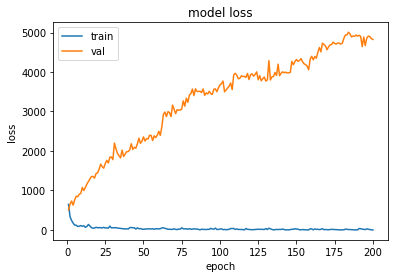

In [50]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.plot( epochs, history.history[ 'val_loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

In [51]:
print( "\n 테스트 정확도: {:.4f}".format( model.evaluate( X_test, y_test )[ 1 ] ) )

67/67 [==============================] - 0s 3ms/sample - loss: 4825.2126 - accuracy: 0.2687

 테스트 정확도: 0.2687


### 훈련 결과에 대한 예측 평가

In [52]:
movie_df[ n_of_train: ]

,Unnamed: 0,title,story,genre,genre_code
332,332,식스 센스,아동 심리학자 말콤 크로우Malcolm Crowe 브루스 윌리스 분가 뛰어난 의사라...,드라마,0
333,333,"제자, 옥한흠",그는 미쳤던 사람이었다 복음에 미쳤고 한 사람 한 사람을 살리기 위해 미쳤다 주일...,다큐멘터리,2
334,334,러시 : 더 라이벌,타고난 천재 레이서 제임스 헌트와 철저한 노력파 천재 니키 라우다그들은 매 경기마다...,액션,3
335,335,다이 하드 3,싸이코 테러리스트 사이먼제레미 아이런스 분은 백화점을 폭파한 후 제2의 범행을 하겠...,액션,3
336,336,택시운전사,택시운전사 만섭송강호은 외국손님을 태우고 광주에 갔다 통금 전에 돌아오면 밀린 월...,드라마,0
...,...,...,...,...,...
1102,1102,개들의 섬,인류를 위협하는 개 독감이 퍼지자 세상의 모든 개들은 쓰레기 섬으로 추방되고 자신이...,애니메이션,5
1103,1103,위대한 개츠비,1922년 뉴욕 외곽에서 살고 있는 닉은 호화로운 별장에 살고 있는 이웃 개츠비에게...,드라마,0
1104,1104,샬롯의 거미줄,어느 봄 비바람치던 밤에 세상에 태어난 새끼 돼지 윌버 너무 조그맣다는 이유로 윌버...,코미디,11
1105,1105,사쿠란,안노 모요코의 동명의 인기 만화를 영화화하는 작품벚꽃이 한창인 봄 8세 나이로 요시...,드라마,0


In [53]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [54]:
def prediction( pred ):
    max_length = len( title_pred_X )
    true_count = 0
    false_count = 0
    
    print( '{0:^50}{1:^20}{2:^20}'.format( '영화제목','실제 장르', '예측 장르' ) )
    print( '{0:=^100}'.format( '=' ) )
    for i in range( max_length ):
        print( '{0:50}\t{1:20}\t{2:20}'.format( title_pred_X[ i ].strip(), 
                                            genres_list[ genre_code_pred_X[ i ] ], 
                                            genres_list[ pred[ i ] ] ) )
        if movie_genre_codes[ i ] == pred[ i ]:
            true_count += 1
        else:
            false_count += 1 

    print( '{0:=^100}'.format( '=' ) )
    print( 'true count : {0}\tfalse count : {1}'.format( true_count, false_count ) )        
    print( '{0:=^100}'.format( '=' ) )
    print( '재현율( Recall ) : {0}'.format( round( true_count / ( true_count + false_count ), 3 ) ) )        
    print( '{0:=^100}'.format( '=' ) )    
    print( '정확도( Accuracy ) : {}'.format( round( true_count / len( pred ) * 100, 3 ) ) )

In [55]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
식스 센스                                             	드라마                 	드라마                 
제자, 옥한흠                                           	다큐멘터리               	다큐멘터리               
러시 : 더 라이벌                                        	액션                  	액션                  
다이 하드 3                                           	액션                  	액션                  
택시운전사                                             	드라마                 	범죄                  
엑스맨: 퍼스트 클래스                                      	SF                  	액션                  
인디아나 존스 - 최후의 성전                                  	모험                  	드라마                 
타오르는 여인의 초상                                       	드라마                 	드라마                 
레이                                                	드라마                 	드라마                 
슈퍼스타 감사용                                          	드라마                 	

## 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 영화 장르 분류

### 훈련

In [56]:
model = Sequential()

model.add( Dense( 256, input_shape = ( vocab_size, ), activation='relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( 128, activation = 'relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( num_classes, activation = 'softmax' ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, batch_size = 128, epochs = 200, verbose = 1, validation_split = 0.1 )

Train on 238 samples, validate on 27 samples
Epoch 1/200
238/238 [==============================] - 1s 4ms/sample - loss: 785.6804 - accuracy: 0.0672 - val_loss: 264.7559 - val_accuracy: 0.2593
Epoch 2/200
238/238 [==============================] - 0s 566us/sample - loss: 422.2359 - accuracy: 0.1891 - val_loss: 241.8431 - val_accuracy: 0.2593
Epoch 3/200
238/238 [==============================] - 0s 580us/sample - loss: 357.0001 - accuracy: 0.1723 - val_loss: 200.3349 - val_accuracy: 0.2593
Epoch 4/200
238/238 [==============================] - 0s 557us/sample - loss: 290.1035 - accuracy: 0.2101 - val_loss: 147.4311 - val_accuracy: 0.1481
Epoch 5/200
238/238 [==============================] - 0s 443us/sample - loss: 217.8595 - accuracy: 0.2227 - val_loss: 121.7632 - val_accuracy: 0.1481
Epoch 6/200
238/238 [==============================] - 0s 415us/sample - loss: 202.2021 - accuracy: 0.2353 - val_loss: 103.5036 - val_accuracy: 0.1481
Epoch 7/200
238/238 [==============================

Epoch 110/200
238/238 [==============================] - 0s 436us/sample - loss: 2.8802 - accuracy: 0.3992 - val_loss: 26.2795 - val_accuracy: 0.1481
Epoch 111/200
238/238 [==============================] - 0s 383us/sample - loss: 2.1897 - accuracy: 0.4202 - val_loss: 26.4561 - val_accuracy: 0.1481
Epoch 112/200
238/238 [==============================] - 0s 398us/sample - loss: 3.2760 - accuracy: 0.4076 - val_loss: 26.6125 - val_accuracy: 0.1481
Epoch 113/200
238/238 [==============================] - 0s 406us/sample - loss: 2.0754 - accuracy: 0.4244 - val_loss: 26.7471 - val_accuracy: 0.1481
Epoch 114/200
238/238 [==============================] - 0s 415us/sample - loss: 2.2954 - accuracy: 0.3950 - val_loss: 26.8689 - val_accuracy: 0.1481
Epoch 115/200
238/238 [==============================] - 0s 381us/sample - loss: 3.0330 - accuracy: 0.3992 - val_loss: 26.9573 - val_accuracy: 0.1481
Epoch 116/200
238/238 [==============================] - 0s 386us/sample - loss: 3.5323 - accuracy: 

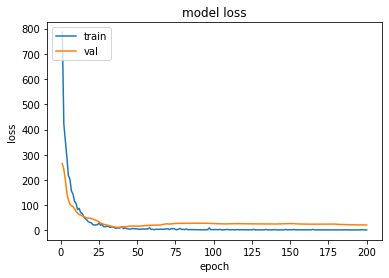

In [57]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.plot(epochs, history.history[ 'val_loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

In [58]:
print( "\n 테스트 정확도: {:.4f}".format( model.evaluate( X_test, y_test )[ 1 ] ) )

67/67 [==============================] - 0s 268us/sample - loss: 52.0623 - accuracy: 0.3582

 테스트 정확도: 0.3582


### 훈련 결과에 대한 예측 평가

In [59]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [60]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
식스 센스                                             	드라마                 	드라마                 
제자, 옥한흠                                           	다큐멘터리               	드라마                 
러시 : 더 라이벌                                        	액션                  	드라마                 
다이 하드 3                                           	액션                  	드라마                 
택시운전사                                             	드라마                 	드라마                 
엑스맨: 퍼스트 클래스                                      	SF                  	드라마                 
인디아나 존스 - 최후의 성전                                  	모험                  	드라마                 
타오르는 여인의 초상                                       	드라마                 	드라마                 
레이                                                	드라마                 	드라마                 
슈퍼스타 감사용                                          	드라마                 	

## RNN으로 영화 장르 분류

In [400]:
input_dim = X_train.shape[ 0 ]

In [401]:
input_length = X_train.shape[ 1 ]

In [402]:
vocab_size

14083

In [403]:
max_word_length

593

### 훈련

In [405]:
model = Sequential()
model.add( Embedding( vocab_size, 256, input_length = input_length ) )
model.add( SimpleRNN( 32, input_length = input_length, input_dim = input_dim ) )
model.add( Dense( num_classes, activation = 'softmax' ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, epochs = 20, verbose = 1 )

Train on 265 samples
Epoch 1/20
265/265 [==============================] - 365s 1s/sample - loss: 2.9770 - accuracy: 0.0491
Epoch 2/20
265/265 [==============================] - 380s 1s/sample - loss: 2.3475 - accuracy: 0.6642
Epoch 3/20
265/265 [==============================] - 271s 1s/sample - loss: 1.7738 - accuracy: 0.9736
Epoch 4/20
265/265 [==============================] - 300s 1s/sample - loss: 1.4047 - accuracy: 0.9962
Epoch 5/20
265/265 [==============================] - 339s 1s/sample - loss: 1.1074 - accuracy: 1.0000
Epoch 6/20
265/265 [==============================] - 249s 939ms/sample - loss: 0.8686 - accuracy: 1.0000
Epoch 7/20
265/265 [==============================] - 220s 830ms/sample - loss: 0.6879 - accuracy: 1.0000
Epoch 8/20
265/265 [==============================] - 259s 978ms/sample - loss: 0.5535 - accuracy: 1.0000
Epoch 9/20
265/265 [==============================] - 238s 900ms/sample - loss: 0.4546 - accuracy: 1.0000
Epoch 10/20
265/265 [===================

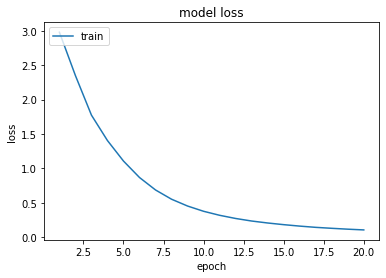

In [407]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

In [408]:
print( "\n 테스트 정확도: {:.4f}".format( model.evaluate( X_test, y_test )[ 1 ] ) )

67/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### 훈련 결과에 대한 예측 평가

In [409]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [410]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
식스 센스                                             	드라마                 	애니메이션               
제자, 옥한흠                                           	다큐멘터리               	액션                  
러시 : 더 라이벌                                        	액션                  	액션                  
다이 하드 3                                           	액션                  	애니메이션               
택시운전사                                             	드라마                 	애니메이션               
엑스맨: 퍼스트 클래스                                      	SF                  	드라마                 
인디아나 존스 - 최후의 성전                                  	모험                  	코미디                 
타오르는 여인의 초상                                       	드라마                 	드라마                 
레이                                                	드라마                 	판타지                 
슈퍼스타 감사용                                          	드라마                 	

## TF-IDF 사용 단어 표현 방법을 이용한 Softmax regression

In [61]:
tokenizer = Tokenizer( num_words = max_words + 2, oov_token = 'OOV' ) # 상위 10000개 단어만 사용
tokenizer.fit_on_texts( movie_token_storys )

In [62]:
movie_tfidf = tokenizer.texts_to_matrix( movie_token_storys, mode = 'tfidf' ).round( 2 )

In [63]:
movie_tfidf

array([[ 0.  ,  0.  ,  1.27, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.27, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  , 18.29,  1.27, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , 21.59,  1.27, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , 18.29,  1.27, ...,  0.  ,  0.  ,  0.  ]])

In [64]:
movie_tfidf.shape

(1107, 10002)

In [65]:
max_words_len = max( len( l ) for l in movie_tfidf )
vocab_size = len( tokenizer.word_index ) + 1 
max_words_len, vocab_size

(10002, 14120)

In [66]:
X = movie_tfidf[ :n_of_train ] # 학습용 feature X
pred_X = movie_tfidf[ n_of_train: ] # 학습 후 테스트 feature X

In [67]:
( X_train, X_test, y_train, y_test ) = train_test_split( X, y, train_size = 0.8, random_state = 2)

In [68]:
print( '훈련 샘플 본문의 크기 : {}'.format( X_train.shape ) )
print( '훈련 샘플 레이블의 크기 : {}'.format( y_train.shape ) )
print( '테스트 샘플 본문의 크기 : {}'.format( X_test.shape ) )
print( '테스트 샘플 레이블의 크기 : {}'.format( y_test.shape ) )

훈련 샘플 본문의 크기 : (265, 10002)
훈련 샘플 레이블의 크기 : (265, 21)
테스트 샘플 본문의 크기 : (67, 10002)
테스트 샘플 레이블의 크기 : (67, 21)


### 훈련

In [69]:
model = Sequential()

model.add( Dense( num_classes, input_dim = max_words_len, activation = 'softmax' ) )
sgd = optimizers.SGD( lr = 0.01 )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, batch_size = 1, epochs = 200, validation_data = ( X_test, y_test ) )

Train on 265 samples, validate on 67 samples
Epoch 1/200
265/265 [==============================] - 1s 5ms/sample - loss: 2.5593 - accuracy: 0.2792 - val_loss: 2.1691 - val_accuracy: 0.5224
Epoch 2/200
265/265 [==============================] - 1s 4ms/sample - loss: 0.2598 - accuracy: 0.9925 - val_loss: 2.1776 - val_accuracy: 0.5373
Epoch 3/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0890 - accuracy: 1.0000 - val_loss: 2.2152 - val_accuracy: 0.5522
Epoch 4/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0478 - accuracy: 1.0000 - val_loss: 2.2441 - val_accuracy: 0.5522
Epoch 5/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0291 - accuracy: 1.0000 - val_loss: 2.2697 - val_accuracy: 0.5522
Epoch 6/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0197 - accuracy: 1.0000 - val_loss: 2.2906 - val_accuracy: 0.5522
Epoch 7/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0143 -

Epoch 56/200
265/265 [==============================] - 1s 4ms/sample - loss: 9.5379e-06 - accuracy: 1.0000 - val_loss: 2.9561 - val_accuracy: 0.5522
Epoch 57/200
265/265 [==============================] - 1s 3ms/sample - loss: 8.3490e-06 - accuracy: 1.0000 - val_loss: 2.9694 - val_accuracy: 0.5522
Epoch 58/200
265/265 [==============================] - 1s 4ms/sample - loss: 7.3135e-06 - accuracy: 1.0000 - val_loss: 2.9833 - val_accuracy: 0.5522
Epoch 59/200
265/265 [==============================] - ETA: 0s - loss: 6.4779e-06 - accuracy: 1.00 - 1s 3ms/sample - loss: 6.4116e-06 - accuracy: 1.0000 - val_loss: 2.9975 - val_accuracy: 0.5672
Epoch 60/200
265/265 [==============================] - 1s 3ms/sample - loss: 5.6118e-06 - accuracy: 1.0000 - val_loss: 3.0123 - val_accuracy: 0.5522
Epoch 61/200
265/265 [==============================] - 1s 3ms/sample - loss: 4.9150e-06 - accuracy: 1.0000 - val_loss: 3.0253 - val_accuracy: 0.5522
Epoch 62/200
265/265 [==============================] 

265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1830 - val_accuracy: 0.5522
Epoch 165/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1833 - val_accuracy: 0.5522
Epoch 166/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1835 - val_accuracy: 0.5522
Epoch 167/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1839 - val_accuracy: 0.5522
Epoch 168/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1841 - val_accuracy: 0.5522
Epoch 169/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.1842 - val_accuracy: 0.5522
Epoch 170/200
265/265 [==============================] - 1s 3ms/sample - loss: 0.0000e+00 - accuracy: 1.0000

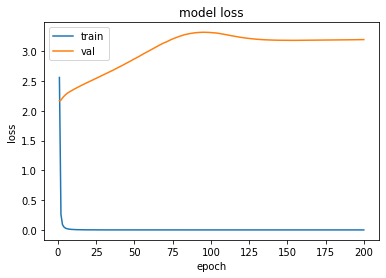

In [70]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.plot( epochs, history.history[ 'val_loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

In [71]:
print( "\n 테스트 정확도: {:.4f}".format( model.evaluate( X_test, y_test )[ 1 ] ) )

67/67 [==============================] - 0s 2ms/sample - loss: 3.1947 - accuracy: 0.5522

 테스트 정확도: 0.5522


### 훈련 결과에 대한 예측 평가

In [72]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [73]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
식스 센스                                             	드라마                 	드라마                 
제자, 옥한흠                                           	다큐멘터리               	드라마                 
러시 : 더 라이벌                                        	액션                  	액션                  
다이 하드 3                                           	액션                  	액션                  
택시운전사                                             	드라마                 	드라마                 
엑스맨: 퍼스트 클래스                                      	SF                  	액션                  
인디아나 존스 - 최후의 성전                                  	모험                  	애니메이션               
타오르는 여인의 초상                                       	드라마                 	멜로/로맨스              
레이                                                	드라마                 	드라마                 
슈퍼스타 감사용                                          	드라마                 	

## 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 영화 장르 분류

### 훈련

In [74]:
max_words, num_classes

(10000, 21)

In [75]:
model = Sequential()

model.add( Dense( 256, input_shape = ( max_words_len, ), activation='relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( 128, activation = 'relu' ) )
model.add( Dropout( 0.5 ) )
model.add( Dense( num_classes, activation = 'softmax' ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [ 'accuracy' ] )
history = model.fit( X_train, y_train, batch_size = 128, epochs = 200, verbose = 1, validation_split = 0.1 )

Train on 238 samples, validate on 27 samples
Epoch 1/200
238/238 [==============================] - 1s 4ms/sample - loss: 3.1355 - accuracy: 0.0840 - val_loss: 2.8066 - val_accuracy: 0.1481
Epoch 2/200
238/238 [==============================] - 0s 356us/sample - loss: 2.6723 - accuracy: 0.1891 - val_loss: 2.6243 - val_accuracy: 0.3333
Epoch 3/200
238/238 [==============================] - 0s 442us/sample - loss: 2.0964 - accuracy: 0.4202 - val_loss: 2.5134 - val_accuracy: 0.2963
Epoch 4/200
238/238 [==============================] - 0s 430us/sample - loss: 1.8393 - accuracy: 0.5378 - val_loss: 2.4631 - val_accuracy: 0.3333
Epoch 5/200
238/238 [==============================] - 0s 377us/sample - loss: 1.4747 - accuracy: 0.6513 - val_loss: 2.4469 - val_accuracy: 0.3333
Epoch 6/200
238/238 [==============================] - 0s 318us/sample - loss: 1.2612 - accuracy: 0.6303 - val_loss: 2.4484 - val_accuracy: 0.3704
Epoch 7/200
238/238 [==============================] - 0s 344us/sample - lo

238/238 [==============================] - 0s 347us/sample - loss: 0.0466 - accuracy: 0.9916 - val_loss: 3.1250 - val_accuracy: 0.4815
Epoch 112/200
238/238 [==============================] - 0s 377us/sample - loss: 0.0522 - accuracy: 0.9832 - val_loss: 3.1396 - val_accuracy: 0.4815
Epoch 113/200
238/238 [==============================] - 0s 386us/sample - loss: 0.0242 - accuracy: 0.9916 - val_loss: 3.1586 - val_accuracy: 0.4815
Epoch 114/200
238/238 [==============================] - 0s 335us/sample - loss: 0.0150 - accuracy: 0.9916 - val_loss: 3.1784 - val_accuracy: 0.4815
Epoch 115/200
238/238 [==============================] - 0s 413us/sample - loss: 0.0294 - accuracy: 0.9874 - val_loss: 3.1955 - val_accuracy: 0.4815
Epoch 116/200
238/238 [==============================] - 0s 417us/sample - loss: 0.0067 - accuracy: 1.0000 - val_loss: 3.2153 - val_accuracy: 0.4444
Epoch 117/200
238/238 [==============================] - 0s 423us/sample - loss: 0.0111 - accuracy: 1.0000 - val_loss: 3

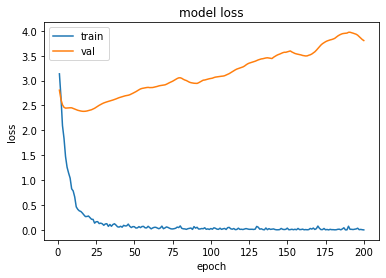

In [76]:
epochs = range( 1, len( history.history[ 'accuracy' ] ) + 1 )
plt.plot( epochs, history.history[ 'loss' ] )
plt.plot(epochs, history.history[ 'val_loss' ] )
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend( [ 'train', 'val' ], loc = 'upper left' )
plt.show()

In [77]:
print( "\n 테스트 정확도: {:.4f}".format( model.evaluate( X_test, y_test )[ 1 ] ) )

67/67 [==============================] - 0s 268us/sample - loss: 2.9696 - accuracy: 0.5821

 테스트 정확도: 0.5821


### 훈련 결과에 대한 예측 평가

In [78]:
pred_genre_code = model.predict_classes( pred_X, verbose = 0 )

In [79]:
prediction( pred_genre_code )

                       영화제목                              실제 장르               예측 장르        
식스 센스                                             	드라마                 	드라마                 
제자, 옥한흠                                           	다큐멘터리               	드라마                 
러시 : 더 라이벌                                        	액션                  	액션                  
다이 하드 3                                           	액션                  	액션                  
택시운전사                                             	드라마                 	드라마                 
엑스맨: 퍼스트 클래스                                      	SF                  	드라마                 
인디아나 존스 - 최후의 성전                                  	모험                  	애니메이션               
타오르는 여인의 초상                                       	드라마                 	멜로/로맨스              
레이                                                	드라마                 	드라마                 
슈퍼스타 감사용                                          	드라마                 	